<a href="https://colab.research.google.com/github/sfwtopoulos/stocks/blob/master/Stocks_seq_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import math
import warnings
import numpy as np
import time

import pandas_datareader as pdr
#%tensorflow_version 2.x
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
import keras


from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [192]:
print(keras.__version__)
print(tf.__version__)
#print(tensorflow.compat.v2.__version__)

2.2.5
1.15.0


In [0]:
#Data import from git repo
url = 'https://raw.githubusercontent.com/sfwtopoulos/stocks/master/stocks_dataset/combined.csv'
#df1 = pd.read_csv(url, error_bad_lines=False)
dfstocks = pd.read_csv(url, sep=',')

In [194]:
#fix column names
dfstocks=dfstocks.rename({' AAPL':'Company', ' Close/Last':'Close', ' Volume':'Volume', ' Open':'Open', ' High':'High', ' Low':'Low'}, axis=1);
for col in dfstocks.columns: 
    print(col) 

Date
Close
Volume
Open
High
Low
Company


In [0]:
#drop $sign from values
dfstocks.Close=dfstocks['Close'].astype(str)
dfstocks.Close=dfstocks.Close.apply(lambda x: x.replace('$',''))
dfstocks.Open=dfstocks['Open'].astype(str)
dfstocks.Open=dfstocks.Open.apply(lambda x: x.replace('$',''))
dfstocks.High=dfstocks['High'].astype(str)
dfstocks.High=dfstocks.High.apply(lambda x: x.replace('$',''))
dfstocks.Low=dfstocks['Low'].astype(str)
dfstocks.Low=dfstocks.Low.apply(lambda x: x.replace('$',''))

In [196]:
#drop rows containing nan or header from the csv files
dfstocks=dfstocks[~dfstocks.Low.str.contains("nan")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("Low")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("N/A")]
dfstocks=dfstocks[~dfstocks.Volume.str.contains("N/A")]
dfstocks.reset_index(drop=True, inplace=True)
dfstocks.Date.count()

229269

In [197]:
#sort dataframe based on date and Company Name
dfstocks = dfstocks.sort_values(['Date', 'Company'])
dfstocks.head(100)

,Date,Close,Volume,Open,High,Low,Company
1761,01/02/2013,78.4328,139906732,79.1171,79.2857,77.3757,AAPL
4248,01/02/2013,35.12,13767660,34.92,35.4,34.1,ABBV
6025,01/02/2013,32.05,20266410,32.3,32.45,31.64,ABT
8512,01/02/2013,69.06,4039095,67.59,69.06,67.55,ACN
10999,01/02/2013,38.34,6483720,37.92,38.73,37.92,ADBE
...,...,...,...,...,...,...,...
10747,01/02/2014,59.29,2745895,59.06,59.53,58.94,ADBE
13234,01/02/2014,168.05,1268722,167.33,170.71,166.5937,AGN
15721,01/02/2014,50.71,9196092,50.81,51.3,50.47,AIG
18208,01/02/2014,53.55,1909106,54.09,54.45,53.5,ALL


In [198]:
#Converting Datatypes
dfstocks.Date=pd.to_datetime(dfstocks.Date)
dfstocks.Close=pd.to_numeric(dfstocks.Close)
dfstocks.Volume=pd.to_numeric(dfstocks.Volume)
dfstocks.Open=pd.to_numeric(dfstocks.Open)
dfstocks.High=pd.to_numeric(dfstocks.High)
dfstocks.Low=pd.to_numeric(dfstocks.Low)
dfstocks.dtypes

Date       datetime64[ns]
Close             float64
Volume              int64
Open              float64
High              float64
Low               float64
Company            object
dtype: object

In [199]:
#dfstocks[dfstocks['Company'].str.contains("AMZN")]
sub_split=dfstocks[dfstocks['Company'].str.contains("MDLZ")]
sub_split.isnull().values.any()
sub_split.isna().values.any()
sub_split = sub_split.sort_values(['Date'])
sub_split.reset_index(drop=True, inplace=True)
sub_split.shape[0]

2487

In [200]:
sub_split

,Date,Close,Volume,Open,High,Low,Company
0,2010-02-16,19.3633,54149150,19.1695,19.3633,18.9288,MDLZ
1,2010-02-17,19.1360,24833350,19.2898,19.3499,19.0157,MDLZ
2,2010-02-18,19.2564,20606450,19.1494,19.2564,19.0324,MDLZ
3,2010-02-19,19.3299,15497250,19.2229,19.4168,19.1494,MDLZ
4,2010-02-22,19.3499,27292690,19.3098,19.4435,19.1494,MDLZ
...,...,...,...,...,...,...,...
2482,2019-12-24,54.9900,1833763,54.9400,55.1800,54.7400,MDLZ
2483,2019-12-26,54.8500,3565549,54.9700,55.0741,54.7200,MDLZ
2484,2019-12-27,55.2800,4229449,54.9300,55.3300,54.8000,MDLZ
2485,2019-12-30,55.0000,3104187,54.9200,55.0700,54.5651,MDLZ


In [0]:
# prepare training and testing data sets for LSTM based sequence modeling
#def dimitris_function(time_series, scaling=True,split_ratio=0.9):
def dimitris_function(time_series,split_ratio=0.9):

    series1 = pd.Series(time_series[time_series.columns[0]])
    series2 = pd.Series(time_series[time_series.columns[1]])
    series3 = pd.Series(time_series[time_series.columns[2]])
    series4 = pd.Series(time_series[time_series.columns[3]])
    series5 = pd.Series(time_series[time_series.columns[4]])

    values1 = series1.values
    values1 = values1.reshape((len(values1), 1))
    values2 = series2.values
    values2 = values2.reshape((len(values2), 1))
    values3 = series3.values
    values3 = values3.reshape((len(values3), 1))
    values4 = series4.values
    values4 = values4.reshape((len(values4), 1))
    values5 = series5.values
    values5 = values5.reshape((len(values5), 1))

    #scaler2 --> Close Price Scaler
    scaler1 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled1"] = scaler1.fit_transform(values1)
    scaler2 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled2"]= scaler2.fit_transform(values2)
    scaler3 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled3"]= scaler3.fit_transform(values3)
    scaler4 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled4"]= scaler4.fit_transform(values4)
    scaler5 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled5"]= scaler5.fit_transform(values5)


    time_series = time_series[["scaled1","scaled2","scaled3","scaled4","scaled5"]].values

        
    split_ratio = int(len(time_series) * split_ratio)

    train = time_series[0:split_ratio]
    test = time_series[split_ratio:len(time_series)]
    
    # return train,test,scaler1,scaler2
    return train,test,scaler2


In [0]:
def get_seq_model(hidden_units=4,input_shape=(1,1)):
    # create and fit the LSTM network
    model = Sequential()
    # samples*timesteps*features
    # https://keras.io/getting-started/sequential-model-guide/
    #relu_advanced=keras.activations.relu(x,)
    model.add(LSTM(input_shape=input_shape,
                   units = hidden_units,  
   #                activation='relu',
                   return_sequences=True
    ))

    # readout layer. TimeDistributedDense uses the same weights for all
    # time steps.
    # model.add(TimeDistributed(Dense(1))) #number of inputs in the 1st layer
    model.add(TimeDistributed(Dense(5)))   
    start = time.time()
    
    model.compile(loss="mse", optimizer="rmsprop")

    print("> Compilation Time : ", time.time() - start)
    print(model.summary())

    return model

In [0]:
# print(type(sub_split.Close))
sub_split_date=sub_split[['Date']]
sub_split=sub_split[['Volume', 'Close', 'Open', 'High', 'Low']]
#sub_split.columns[1]

In [204]:
# split train and test datasets
train,test,scaler_Close = dimitris_function(sub_split,split_ratio=0.7)

#train
print(len(train))
print(train.shape[0])
print(train.shape)
print(test.shape)
print(train)

1740
1740
(1740, 5)
(747, 5)
[[0.88815584 0.02021012 0.01335138 0.01636724 0.01466068]
 [0.39046289 0.01423411 0.01651313 0.01601441 0.01695744]
 [0.31870301 0.01739958 0.01282311 0.01355248 0.01739882]
 ...
 [0.07876951 0.68608191 0.69959394 0.69877535 0.69367717]
 [0.13961111 0.67241044 0.68067072 0.68508332 0.68019791]
 [0.10580105 0.69607261 0.66910654 0.69890701 0.68019791]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [205]:
#We use numpy to reshape our time series into 3D tensors.
train = np.reshape(train,(1,train.shape[0],5))
test = np.reshape(test,(1,test.shape[0],5))

train_x = train[:,:-1,:]
train_y = train[:,1:,:]

test_x = test[:,:-1,:]
test_y = test[:,1:,:]

print("Data Split Complete")

print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))
print("test_x shape={}".format(test_x.shape))
print("test_y shape={}".format(test_y.shape))

Data Split Complete
train_x shape=(1, 1739, 5)
train_y shape=(1, 1739, 5)
test_x shape=(1, 746, 5)
test_y shape=(1, 746, 5)


In [206]:
# build RNN model
seq_lstm_model=None
try:
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],5))
except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],5))

> Compilation Time :  0.024444103240966797
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1739, 4)           160       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1739, 5)           25        
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________
None


In [207]:
train_y

array([[[0.39046289, 0.01423411, 0.01651313, 0.01601441, 0.01695744],
        [0.31870301, 0.01739958, 0.01282311, 0.01355248, 0.01739882],
        [0.23196437, 0.01933199, 0.01475485, 0.01777594, 0.02049112],
        ...,
        [0.07876951, 0.68608191, 0.69959394, 0.69877535, 0.69367717],
        [0.13961111, 0.67241044, 0.68067072, 0.68508332, 0.68019791],
        [0.10580105, 0.69607261, 0.66910654, 0.69890701, 0.68019791]]])

In [208]:
# train the model
seq_lstm_model.fit(train_x, train_y,
                #epochs=20, batch_size=1,
                epochs=250, batch_size=1,
                verbose=1)
print("Model Fit Complete")

Epoch 1/250
1/1 [==============================] - 2s 2s/step - loss: 0.1414
Epoch 2/250
1/1 [==============================] - 1s 861ms/step - loss: 0.1351
Epoch 3/250
1/1 [==============================] - 1s 886ms/step - loss: 0.1305
Epoch 4/250
1/1 [==============================] - 1s 859ms/step - loss: 0.1268
Epoch 5/250
1/1 [==============================] - 1s 826ms/step - loss: 0.1235
Epoch 6/250
1/1 [==============================] - 1s 816ms/step - loss: 0.1206
Epoch 7/250
1/1 [==============================] - 1s 821ms/step - loss: 0.1178
Epoch 8/250
1/1 [==============================] - 1s 810ms/step - loss: 0.1152
Epoch 9/250
1/1 [==============================] - 1s 892ms/step - loss: 0.1128
Epoch 10/250
1/1 [==============================] - 1s 889ms/step - loss: 0.1105
Epoch 11/250
1/1 [==============================] - 1s 868ms/step - loss: 0.1082
Epoch 12/250
1/1 [==============================] - 1s 917ms/step - loss: 0.1061
Epoch 13/250
1/1 [======================

In [209]:
# train fit performance
trainPredict = seq_lstm_model.predict(train_x)
trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.04 RMSE


In [210]:
trainPredict

array([[[0.12552667, 0.11114304, 0.09949882, 0.18189925, 0.12718743],
        [0.14310081, 0.08379331, 0.09865844, 0.166518  , 0.07764621],
        [0.15398672, 0.06198193, 0.09143795, 0.15020642, 0.04513742],
        ...,
        [0.11545254, 0.6709944 , 0.6667575 , 0.655286  , 0.6618559 ],
        [0.11673172, 0.67204094, 0.66949624, 0.65548843, 0.6609008 ],
        [0.1212827 , 0.6702379 , 0.67387503, 0.6547202 , 0.6546721 ]]],
      dtype=float32)

In [0]:
# Pad input sequence
testPredict = pad_sequences(test_x,maxlen=train_x.shape[1],padding='post',dtype='float64')

In [212]:
# forecast values
testPredict = seq_lstm_model.predict(testPredict)
testPredict

array([[[0.07230058, 0.28655076, 0.1617999 , 0.2478413 , 0.42381898],
        [0.08231367, 0.3891809 , 0.27313122, 0.3290736 , 0.5327633 ],
        [0.08831815, 0.46319187, 0.3606185 , 0.3936264 , 0.5884907 ],
        ...,
        [0.1195783 , 0.0308558 , 0.00746114, 0.07364118, 0.01515351],
        [0.1195783 , 0.0308558 , 0.00746114, 0.07364118, 0.01515351],
        [0.1195783 , 0.0308558 , 0.00746114, 0.07364118, 0.01515351]]],
      dtype=float32)

In [0]:
#Drop all other variables except Close Price Output
testPredict=np.delete(testPredict, [2,3,4], 2)
trainPredict=np.delete(trainPredict, [2,3,4], 2)
# testPredict=np.delete(testPredict, 3, 2)
# trainPredict=np.delete(trainPredict, 3, 2)
# testPredict=np.delete(testPredict, 4, 2)
# trainPredict=np.delete(trainPredict, 4, 2)
testPredict=np.delete(testPredict, 0, 2)
trainPredict=np.delete(trainPredict, 0, 2)

In [214]:
testPredict

array([[[0.28655076],
        [0.3891809 ],
        [0.46319187],
        ...,
        [0.0308558 ],
        [0.0308558 ],
        [0.0308558 ]]], dtype=float32)

In [215]:
trainPredict


array([[[0.11114304],
        [0.08379331],
        [0.06198193],
        ...,
        [0.6709944 ],
        [0.67204094],
        [0.6702379 ]]], dtype=float32)

In [216]:
type(testPredict)

numpy.ndarray

In [0]:
# # inverse transformation of the Close Price
trainPredict = scaler_Close.inverse_transform(trainPredict.\
                                        reshape(-1,1))
testPredict = scaler_Close.inverse_transform(testPredict.\
                                       reshape(-1,1))

In [218]:
trainPredict

array([[22.82197 ],
       [21.781712],
       [20.952108],
       ...,
       [44.11614 ],
       [44.155945],
       [44.087364]], dtype=float32)

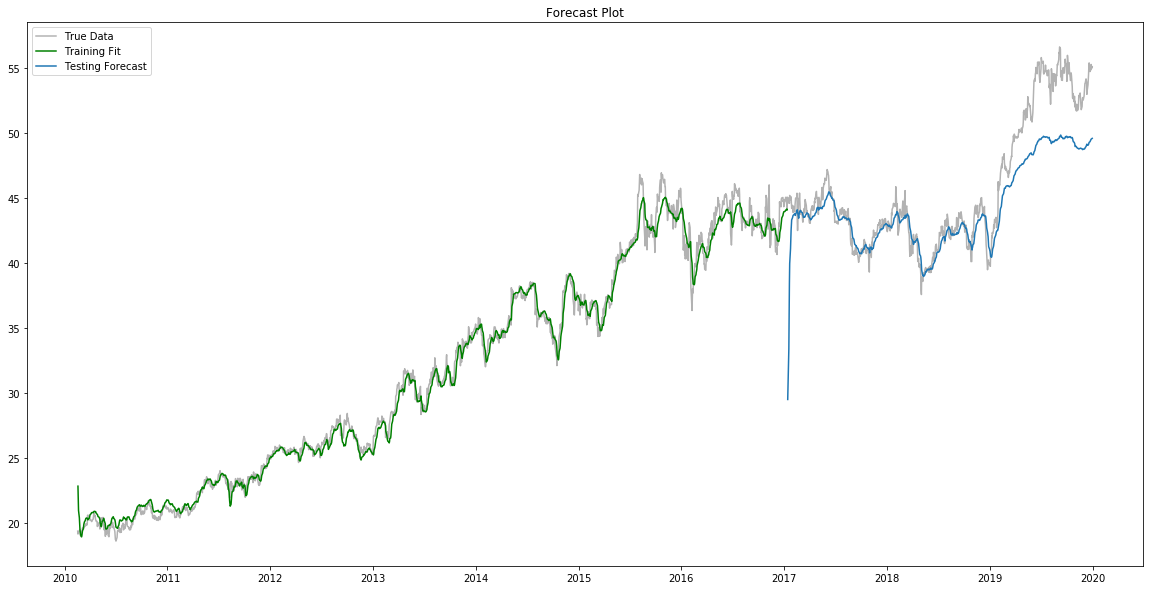

In [219]:
# plot the true and forecasted values
split_ratio = len(trainPredict)+1

plt.plot(sub_split_date.Date,
          sub_split.Close.values,c='black',
          alpha=0.3,label='True Data')

plt.plot(sub_split_date.Date[1:split_ratio],
          trainPredict,label='Training Fit',c='g')

plt.plot(sub_split_date.Date[split_ratio+1:],
          testPredict[:test_x.shape[1]],label='Testing Forecast')
plt.title('Forecast Plot')
plt.legend()
#plt.show()
plt.rcParams["figure.figsize"] = (20,10)
plt.show()